In [1]:
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging
import copy

import numpy as np
from astropy.table import Table as ApTable

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

import lsst.afw.table as afwTable
import lsst.log as log
import lsst.meas.deblender
from lsst.meas.deblender import nmf, proximal, sim
import lsst.meas.deblender.utils as debUtils
from lsst.meas.deblender.baseline import newDeblend

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
log.setLevel("", log.INFO)

# Load the Simulated Data

In [2]:
def loadSimData(testNbr, filters):
    logger.info("Loading Data for test {0}".format(testNbr))
    dataPath = os.path.abspath(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..','data', 'sim_data'))
    imgFilename = os.path.join(dataPath, "test"+str(testNbr)+"/{0}_{1}.fits")
    catFilename = os.path.join(dataPath, "test"+str(testNbr)+"/det_merge.fits")
    simFilename = os.path.join(dataPath, "test"+str(testNbr)+"/catalog_true.fits")
    expDb = proximal.ExposureDeblend(filters, imgFilename, catFilename, simFilename)
    return expDb

# Match the peaks and the simulated sources

And note any sources without matches, or multiple sources with the same match

In [3]:
filters = ["g","r", "i","z",'y']
expDbs = [loadSimData(n, filters) for n in range(1,2)]
peakTables = []
simTables = []
for n, expDb in enumerate(expDbs):
    logger.info("Test {0}".format(n+1))
    # Estimate the noise in the image
    avgNoise = sim.getNoise(expDb.calexps)
    # Build a table with 
    peakTable = sim.buildPeakTable(expDb, filters)
    peakTables.append(peakTable)
    #tbl.add_row([1,0,402,60,False, tbl[0]["Peak"]])
    simTable, idx = sim.matchToRef(peakTable, expDb.simTable, filters, avgNoise=avgNoise,
                                 display=False)#, calexp=expDb.calexps[1])
    simTables.append(simTable)
    # Calculate the flux for isolated (non-blended) sources
    sim.calculateIsolatedFlux(filters, expDb, peakTable, simTable)

nmfPeakTables = copy.deepcopy(peakTables)

INFO:lsst.meas.deblender:Loading Data for test 1
INFO:lsst.meas.deblender.proximal:Total parents: 25
INFO:lsst.meas.deblender.proximal:Unblended sources: 17
INFO:lsst.meas.deblender.proximal:Sources with multiple peaks: 8
INFO:lsst.meas.deblender:Test 1
INFO:lsst.meas.deblender:Sources not detected: 14


# Deblend and Calculate Flux

In [4]:
deblenderResults = []
for n,expDb in enumerate(expDbs):
    logger.info("Deblending Test {0}".format(n+1))
    # Run the old deblender and calculate the flux of blended objects
    deblenderResult = sim.deblendSimExposuresOld(filters, expDb, peakTables[n])
    deblenderResults.append(deblenderResult)
    
    # Run the new deblender and calculate the flux of blended objects
    expDb.deblend()
    sim.calculateNmfFlux(expDb, nmfPeakTables[n])

INFO:lsst.meas.deblender:Deblending Test 1


constraints MMMMMMMMMMMMMMMMMMMMMMM
0 0.70386091192 0 20.5454786703 49 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1 0.00588503255343 49 15.4910547973 49 [17086, 18362, 17742, 17384, 17460, 17292, 17313, 18683, 18601, 18570, 18202, 17884, 18231, 18396, 18897, 17067, 17960, 17703, 17281, 17859, 17116, 18452, 18516]
2 0.00326213562535 49 11.6052922516 49 [19710, 20342, 19728, 19874, 19681, 19934, 19639, 20180, 20123, 20106, 20356, 19941, 18906, 19770, 20286, 19860, 20069, 19970, 19657, 20090, 19427, 20086, 20057]
3 0.00190202657332 49 8.67781405746 49 [19995, 20340, 19862, 20406, 20050, 20403, 19958, 20022, 20346, 20330, 20291, 20388, 17496, 19535, 19962, 20149, 20090, 20375, 19727, 20142, 18971, 20153, 20264]
4 0.00122458314199 49 6.49963439268 49 [20365, 20405, 20077, 20558, 20594, 20672, 20376, 19560, 20030, 20560, 20410, 20836, 17589, 19470, 19806, 20755, 20633, 20581, 20398, 20403, 19940, 20442, 20340]
5 0.000825725915958 49 4.87027327637 49 [20305, 19692, 

In [5]:
apportionTables = copy.deepcopy(peakTables)
for n, expDb in enumerate(expDbs):
    sim.calculateFluxPortion(expDb, apportionTables[n])

In [6]:
import lsst.meas.deblender.sim
reload(lsst.meas.deblender.sim)
from lsst.meas.deblender import sim

import lsst.meas.deblender.proximal
reload(lsst.meas.deblender.proximal)
from lsst.meas.deblender import proximal

# Compare Deblender results to True Values

INFO:lsst.meas.deblender:Total Simulated Sources: 138
INFO:lsst.meas.deblender:Total Detected Sources: 138
INFO:lsst.meas.deblender:Total Matches: 127
INFO:lsst.meas.deblender:Matched Isolated sources: 17
INFO:lsst.meas.deblender:Matched Blended sources: 110
INFO:lsst.meas.deblender:Total Duplicates: 0


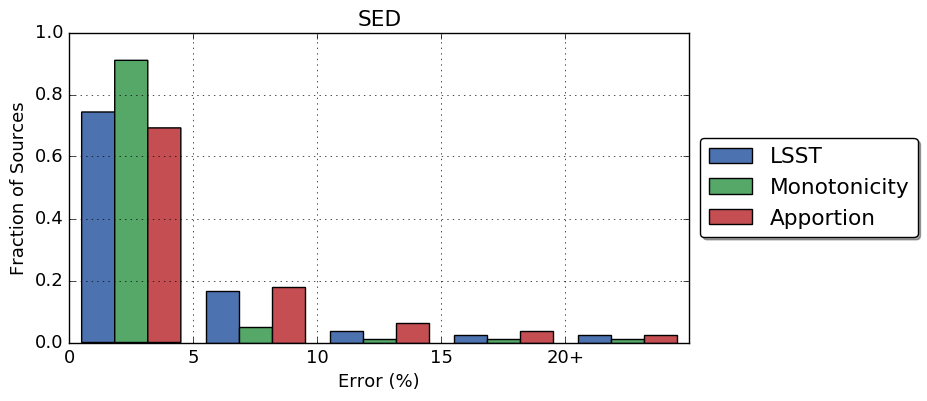

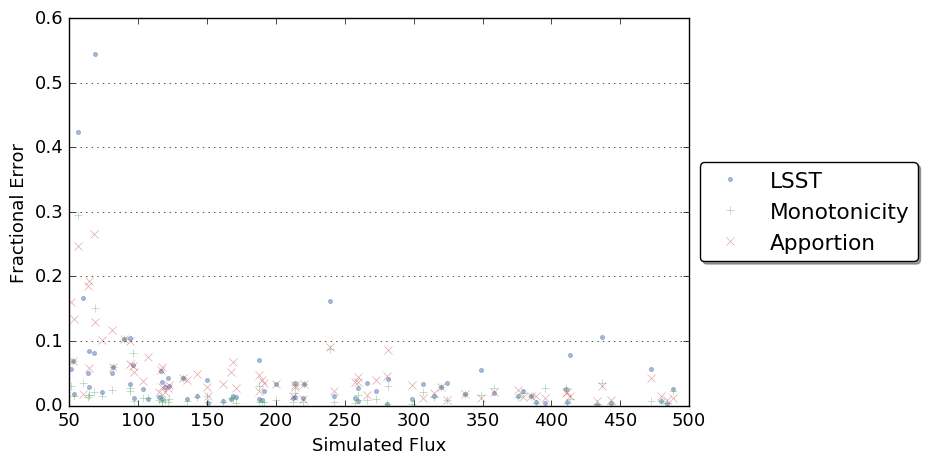

/Users/fred/lsst/code/meas_deblender/python/lsst/meas/deblender/sim.py:340: RuntimeWarning: invalid value encountered in less
  lowFlux = simTable[flux]<minFlux


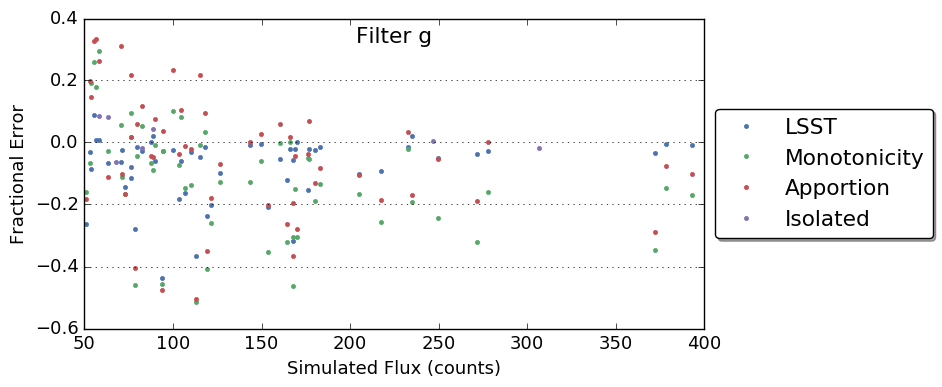

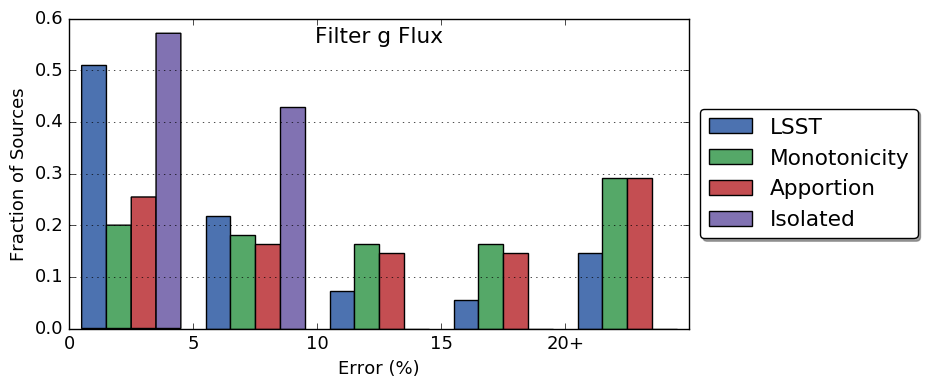

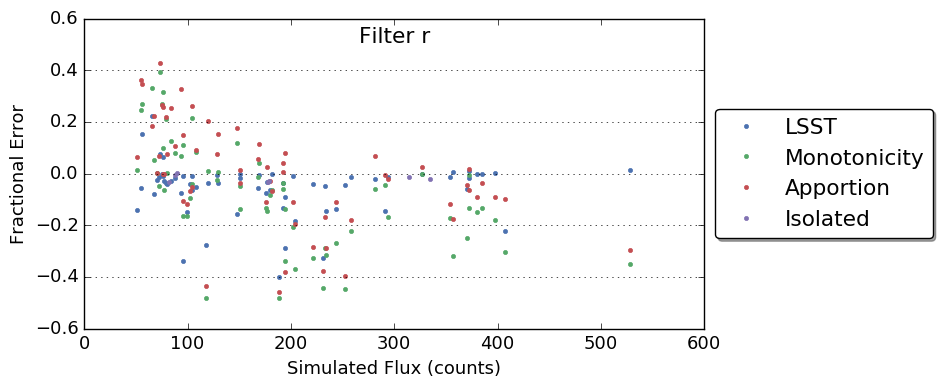

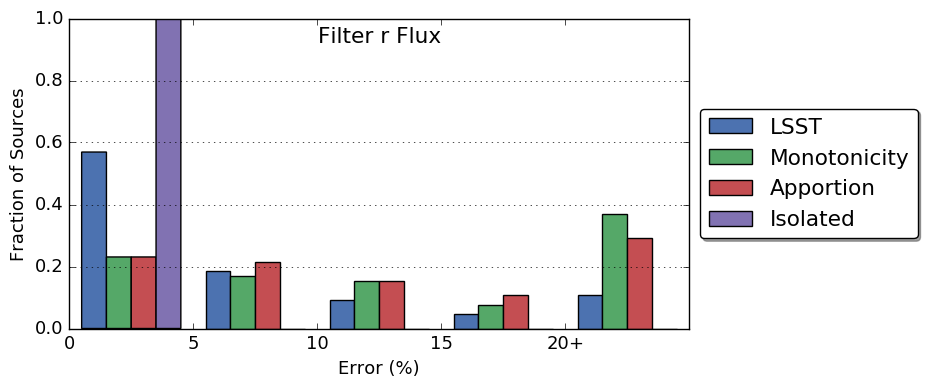

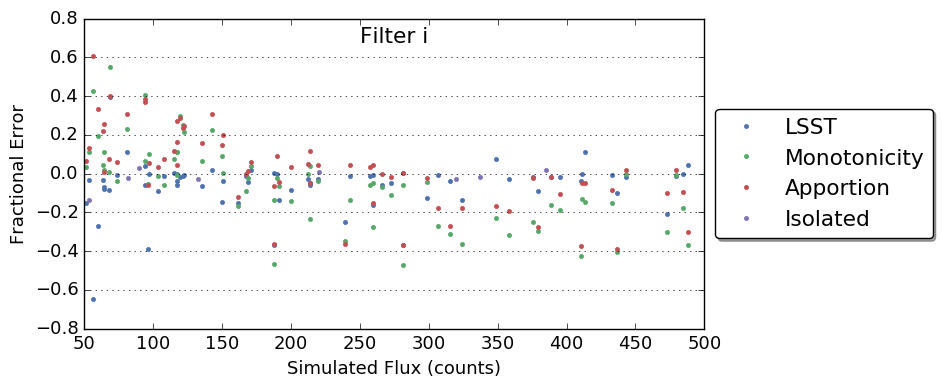

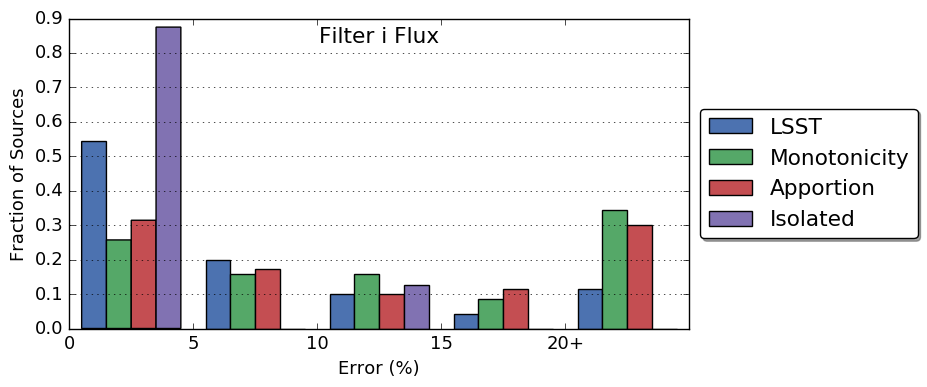

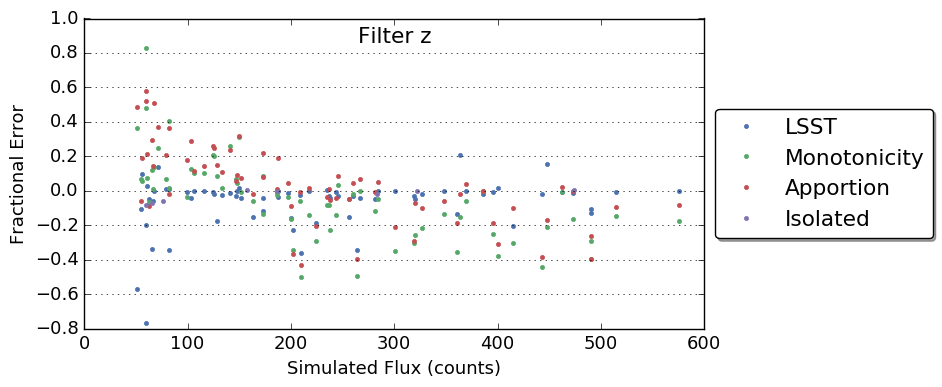

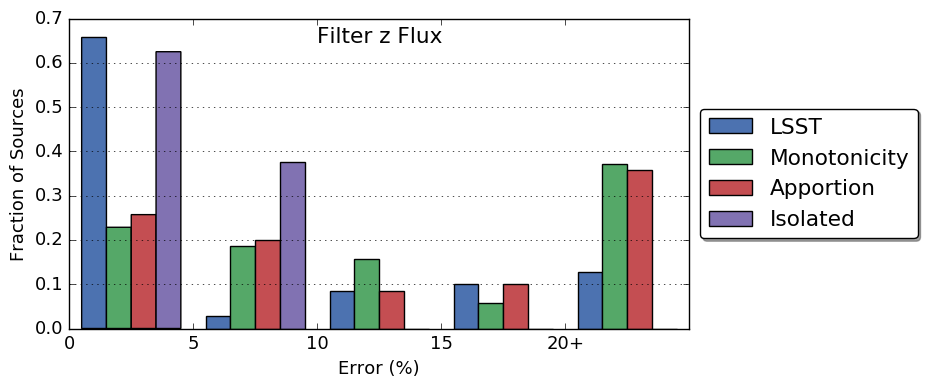

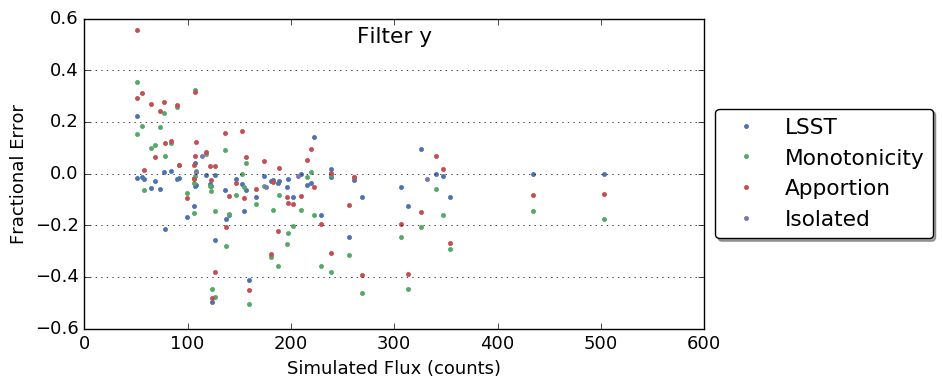

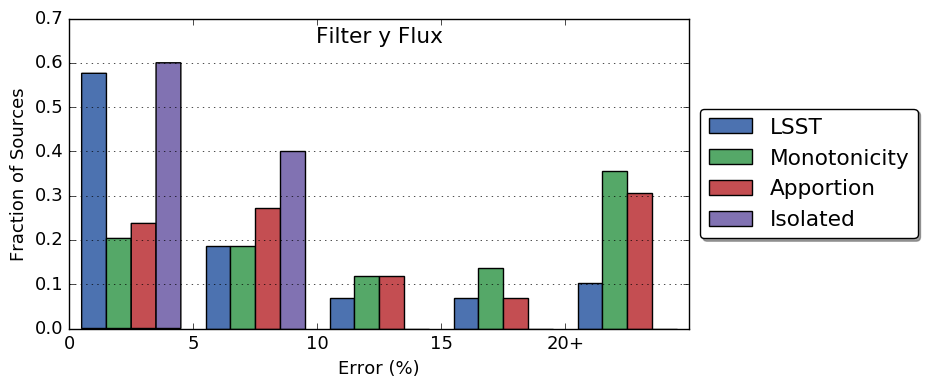

In [7]:
#peakTable, simTable, nmfPeakTable = sim.compareMeasToSim(peakTables, simTables, nmfPeakTables, filters)
deblendedTblDict = OrderedDict([
    ("LSST", peakTables),
    ("Monotonicity", nmfPeakTables),
    ("Apportion", apportionTables)
])
deblendedTables = sim.compareMeasToSim(simTables, deblendedTblDict, filters)

In [6]:
# Ignore this for now, it will be used to check for degenerate templates

parent = expDb.deblendedParents[1]
templates = [parent.getTemplate(0, pk) for pk in range(len(parent.peaks))]
peakCount = len(parent.peaks)
dotFlux = np.zeros((peakCount, peakCount))
degenerateFlux = np.zeros((peakCount, peakCount))
for i in range(peakCount):
    for j in range(i+1):
        dotFlux[i,j] = np.sum(templates[i]*templates[j])

for i in range(peakCount):
    for j in range(i):
        norm = dotFlux[i,i]*dotFlux[j,j]
        if norm<=0:
            degenerateFlux[i,j] = 0
        else:
            degenerateFlux[i,j] /= np.sqrt(norm)

In [7]:
degenerateFlux

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
   